In [24]:
from __future__ import division
import random

from joblib import Parallel, delayed

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix, make_scorer
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


import os

home_dir = os.getcwd()


In [2]:
def balanced_subsample(x, y, subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            this_xs = this_xs.reindex(np.random.permutation(this_xs.index))

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = pd.concat(xs)
    ys = pd.Series(data=np.concatenate(ys),name='target')

    return xs, ys

In [3]:
def normalize_data(x):
    return (x - x.min(0)) / x.ptp(0)

In [4]:
def preprocess_data(data):
    data = data.replace("na", 0)
    data = data.replace("neg", 0)
    data = data.replace("pos", 1)

    return data

In [5]:
def reset_data(with_undersampling=False):
    
    # our training and test datasets
    X_train = pd.read_csv(home_dir + '/scania/training_set_new.csv')
    X_test = pd.read_csv(home_dir + '/scania/test_set_new.csv') 

    X_train = preprocess_data(X_train)
    X_test = preprocess_data(X_test)
    
    y_train = X_train.iloc[:, 0]  # First column in labels
    y_test = X_test.iloc[:, 0]  # First column in labels

    X_train = X_train.drop(X_train.columns[0], axis=1)  # delete first column of xtrain
    X_test = X_test.drop(X_test.columns[0], axis=1)  # delete first column of xtest
    
    if with_undersampling:
        X_train, y_train = balanced_subsample(X_train, y_train)
        
        
    return X_train, X_test, y_train, y_test

In [6]:
def find_cost(predictions, X_train, X_test, y_train, y_test):
    cost_1_instances = 0
    cost_2_instances = 0
    normal_correct = 0
    anomaly_correct = 0
    for i in range(0, len(predictions)):
        if predictions[i] == 0 and y_test[i] == 1:  # He predicted normal but it was anomaly
            cost_2_instances += 1
        elif predictions[i] == 1 and y_test[i] == 0:  # He predicted anomaly but it was normal
            cost_1_instances += 1
        elif predictions[i] == 0 and y_test[i] == 0: # He predicted normal and it was normal
            normal_correct += 1
        elif predictions[i] == 1 and y_test[i] == 1: # He predicted anomaly and it was anomaly
            anomaly_correct += 1

    print (("cost_1_instances are {}".format(cost_1_instances)))
    print (("cost_2_instances are {}".format(cost_2_instances)))
    print (("Correct normal predictions are {}".format(normal_correct)))
    print (("Correct anomaly predictions are {}".format(anomaly_correct)))
    print (("Total Cost is {}".format(10*cost_1_instances + 500*cost_2_instances)))
    

In [18]:
def feature_selection(X_train,y_train, num_of_features, X_test, y_test):
# Build RF classifier to use in feature selection
    random_forest = RandomForestClassifier(criterion="entropy", n_estimators=50)
    #find_cost = find_cost()
    #create new scoring parameter based on cost function
    #cost = make_scorer( find_cost, greater_is_better= False)
    # Build step forward feature selection
    sfs1 = sfs(random_forest,
               k_features= num_of_features,
               forward=True,
               floating=False,
               verbose=2,
               scoring='f1',
               cv=3,
              n_jobs=-1)

    # Perform SFFS
    # with Parallel(n_jobs=2, prefer="threads", verbose=10):
    sfs1 = sfs1.fit(X_train, y_train)

    feat_cols = list(sfs1.k_feature_idx_)
    print(feat_cols)
    
    return feat_cols

In [19]:
def execute_classifier(use_training, clf, X_train, X_test, y_train, y_test):

    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    # predictions = np.round(predictions)

    
    
    if  use_training:
        prediction_prob = clf.predict_proba(X_test)
       
        predictions = []
        true_labels = []
        for pr in prediction_prob:
            if pr[0] > 0.95:
                predictions.append(0)  # Neg
            else:
                predictions.append(1)  # Pos

    accuracy = 0
    for i in range(0, len(predictions)):
        if predictions[i] == y_test[i]:
            accuracy +=1


    conf_mat = confusion_matrix(y_test, predictions)        
    average_precision = average_precision_score(y_test, predictions)

    #find average precision recall
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    precision, recall, _ = precision_recall_curve(y_test, predictions)

    #plot precision recall

    precision, recall, _ = precision_recall_curve(y_test, predictions)

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))

   # write_predictions_to_file(name + '_output.csv.dat', y_test)
    find_cost(predictions, X_train, X_test, y_train, y_test)
    # print ("Accuracy of {} is {} %".format(name, round((accuracy)*100, 5)))

    return predictions, accuracy/len(predictions)

In [20]:
# Getting the data from the csv files
X_train, X_test, y_train, y_test = reset_data(with_undersampling=False) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:  7.0min finished

[2019-11-07 11:00:26] Features: 1/5 -- score: 0.43813868969605835[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:  7.5min finished

[2019-11-07 11:07:55] Features: 2/5 -- score: 0.5410040613291867[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:  7.3min finished

[2019-11-07 11:15:12] Features: 3/5 -- score: 0.6443251

[8, 20, 37, 70, 161]
Average precision-recall score: 0.36
cost_1_instances are 364
cost_2_instances are 21
Correct normal predictions are 14386
Correct anomaly predictions are 229
Total Cost is 14140
Accuracy of Random forest with 5 features is 97.43333 %


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:  7.1min finished

[2019-11-07 11:37:01] Features: 1/10 -- score: 0.4366735320915003[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:  8.2min finished

[2019-11-07 11:45:15] Features: 2/10 -- score: 0.5419618903842552[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:  8.1min finished

[2019-11-07 11:53:20] Features: 3/10 -- score: 0.64652

[8, 21, 37, 40, 51, 57, 70, 82, 118, 165]
Average precision-recall score: 0.38
cost_1_instances are 345
cost_2_instances are 14
Correct normal predictions are 14405
Correct anomaly predictions are 236
Total Cost is 10450
Accuracy of Random forest with 10 features is 97.60667 %


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:  8.2min finished

[2019-11-07 13:02:59] Features: 1/15 -- score: 0.4401246284814994[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:  8.4min finished

[2019-11-07 13:11:23] Features: 2/15 -- score: 0.5463867227337776[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:  8.3min finished

[2019-11-07 13:19:43] Features: 3/15 -- score: 0.66502

[8, 9, 25, 36, 38, 42, 70, 98, 121, 129, 146, 151, 161, 164, 165]
Average precision-recall score: 0.36
cost_1_instances are 396
cost_2_instances are 13
Correct normal predictions are 14354
Correct anomaly predictions are 237
Total Cost is 10460
Accuracy of Random forest with 15 features is 97.27333 %


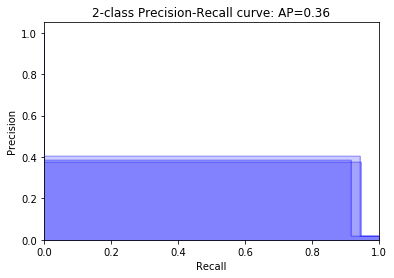

In [22]:
# Define "classifiers" to be used

clf = RandomForestClassifier(criterion="entropy", n_estimators=50)


# executing each classifier
feat_cols = [5, 10, 15]

for i in feat_cols :
    new_feat_cols = feature_selection(X_train,y_train, i,  X_test, y_test)
#feat_cols2 = feature_selection(X_train,y_train, 10,  X_test, y_test)
#feat_cols3 = feature_selection(X_train,y_train, 15,  X_test, y_test)

#feat_columns = [0, 5, 28, 33, 34, 42, 52, 60, 80, 103]

    x_train_less_feat = X_train.iloc[:, new_feat_cols]
    x_test_less_feat = X_test.iloc[:, new_feat_cols]
    
# predictions after feature reduction
    predictions_tocompare, accuracy_tocompare = execute_classifier(True, clf, x_train_less_feat, x_test_less_feat, y_train, y_test)
    print("Accuracy of Random forest with {} features is {} %".format(len(new_feat_cols), round((accuracy_tocompare)*100, 5)))
    
    


   

In [11]:
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(clf, hyperF, scoring="f1", cv = 5, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(x_train_less_feat, y_train)

gridF.best_params_

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800}

Average precision-recall score: 0.27
cost_1_instances are 568
cost_2_instances are 18
Correct normal predictions are 14182
Correct anomaly predictions are 232
Total Cost is 14680
Accuracy of Random forest after GridSearch is 96.09333 %


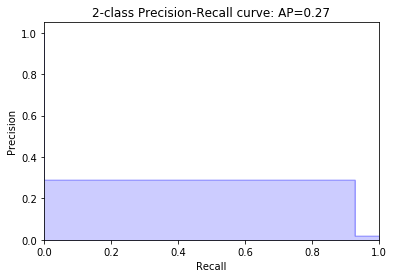

In [17]:
best_grid = gridF.best_estimator_
#predictions = best_grid.predict(x_test_less_feat)
    # predictions = np.round(predictions)

prediction_prob = best_grid.predict_proba(x_test_less_feat)
       
predictions = []
true_labels = []
for pr in prediction_prob:
    if pr[0] > 0.95:
        predictions.append(0)  # Neg
    else:
        predictions.append(1)  # Pos

accuracy = 0
for i in range(0, len(predictions)):
    if predictions[i] == y_test[i]:
        accuracy +=1


conf_mat = confusion_matrix(y_test, predictions)        
average_precision = average_precision_score(y_test, predictions)

#find average precision recall
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
precision, recall, _ = precision_recall_curve(y_test, predictions)

    #plot precision recall

precision, recall, _ = precision_recall_curve(y_test, predictions)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))

# write_predictions_to_file(name + '_output.csv.dat', y_test)
find_cost(predictions, X_train, X_test, y_train, y_test)
# print ("Accuracy of {} is {} %".format(name, round((accuracy)*100, 5)))

print("Accuracy of Random forest after GridSearch is {} %".format(round((accuracy/len(predictions))*100, 5)))
